In [2]:
import numpy as np
import pandas as pd

# Decision Tree Classifier

In this notebook we are going to take you through the how to implement the **[Iterative Deepening 3 (ID3)](https://en.wikipedia.org/wiki/ID3_algorithm)**. 
>**Here we should explain what ID3 is and why it is useful**.

We will start uploading and cleaning a dataset, and then we will implement a series of very useful functions, which in turn will lead us to the implementation of the *DecisionTree* class. This class will define the three most important functions: fit, predict, and print.

So here is the agenda:
1. Dataset Preprocessing
2. Useful Functions Definition
3. DecisionTree class implementation

## 1. Dataset Preprocessing

We will first start by uploading the dataset on which we are going to work. For that purpose we are going to work with *[pandas](https://pandas.pydata.org/)* which is very handy to upload and process dataset files. Let's get started by uploading the file, and taking a look to it.

In [4]:
path = '/home/matlongo/Documents/USC/INF 552 - Machine Learning/homework1/'
dataset = pd.read_csv(path+'dt-data.txt')
dataset

,(Occupied,Price,Music,Location,VIP,Favorite Beer,Enjoy)
0,01: High,Expensive,Loud,Talpiot,No,No,No;
1,02: High,Expensive,Loud,City-Center,Yes,No,Yes;
2,03: Moderate,Normal,Quiet,City-Center,No,Yes,Yes;
3,04: Moderate,Expensive,Quiet,German-Colony,No,No,No;
4,05: Moderate,Expensive,Quiet,German-Colony,Yes,Yes,Yes;
5,06: Moderate,Normal,Quiet,Ein-Karem,No,No,Yes;
6,07: Low,Normal,Quiet,Ein-Karem,No,No,No;
7,08: Moderate,Cheap,Loud,Mahane-Yehuda,No,No,Yes;
8,09: High,Expensive,Loud,City-Center,Yes,Yes,Yes;
9,10: Low,Cheap,Quiet,City-Center,No,No,No;


As we can see, the dataset is quite small (just 22 rows), and only contain 7 features, 6 attributes and one target feature to predict. In our case, the target column to predict is *Enjoy*, and the rest of them are the features we are going to use to train our model, and make predictions.

Besides that, we can also note that some of the attribute names look weird (take *Enjoy)* for instance), and so do some of the attribute values, such as *(Occupied* values have a number before the real value. Therefore, we should do some cleaning to the dataset.

In this block we will: (1) Strip all the fields; (2) Remove punctutation characters from headers; (3) Remove punctuation characters from cells and also the numbers for the first column.

In [5]:
# Here we remove the parenthesis from the header, as well as the extra spaces
dataset.columns = [c.strip().replace('(', '').replace(')', '') for c in dataset.columns]
# Now we will remove the punctuation characters from the Enjoy and Occupied columns
dataset['Enjoy'] = dataset['Enjoy'].apply(lambda enjoy: enjoy[:-1].strip())
dataset['Occupied'] = dataset['Occupied'].apply(lambda occup: occup[4:].strip())
# Finally we remove the spaces from all the cells
dataset = dataset.applymap(lambda s: s.strip())
dataset

,Occupied,Price,Music,Location,VIP,Favorite Beer,Enjoy
0,High,Expensive,Loud,Talpiot,No,No,No
1,High,Expensive,Loud,City-Center,Yes,No,Yes
2,Moderate,Normal,Quiet,City-Center,No,Yes,Yes
3,Moderate,Expensive,Quiet,German-Colony,No,No,No
4,Moderate,Expensive,Quiet,German-Colony,Yes,Yes,Yes
5,Moderate,Normal,Quiet,Ein-Karem,No,No,Yes
6,Low,Normal,Quiet,Ein-Karem,No,No,No
7,Moderate,Cheap,Loud,Mahane-Yehuda,No,No,Yes
8,High,Expensive,Loud,City-Center,Yes,Yes,Yes
9,Low,Cheap,Quiet,City-Center,No,No,No


Great, now everything is set to start implementing the functions.

## 2. Useful Functions Definition

Once the dataset is ready to be used, we will move forwards to implement a couple of functions that form the pieces necessary to implement our final algorithm ID3. 

In order to determine what attribute to use for the split, we are going to use the *Information Gain* metric, which is defined by the following formulae:

$Information\_Gain = Entropy\_Father-Entropy\_child$

So, we need to calculate the Entropy for a given dataset. The Entropy for a probability distribution $\vec{p}$ is calculated with the following formulae:

$Entropy(\vec{p}) = -\sum_{i=1}^{t}p_i*\log(p_i)$

Where *t* is the number of elements in $\vec{p}$.

In our case we want to predict the Entropy for our *target* column. We will call *target* column to the column we will try to estimate, for the shown dataset the target is *Enjoy*. Therefore, to calculate the Entropy for that column, we first need to calculate the probability distribution for each possible value of it:

$\vec{p_{target}} = [\frac{N_{yes}}{N}, \frac{N_{no}}{N}]$

That is, since *Enjoy* only has two possible values (*Yes* and *No*) the probability distribution for it is going to be the number of rows where *Enjoy* is *Yes* ($N_{yes}$) divided by the total number of rows ($N$), and something similar with the number of rows where *Enjoy* is *No*.

We will define a function *get_entropy* that given the dataset, and the target column returns the entropy obtained.

In [97]:
def get_entropy(dataset, target):
    """
    This method returns the entropy for a target column in a given dataset. It basically gets the distribution
    of each class, and based on that it calculates the entropy.
    - dataset: Pandas DataFrame containing all the dataset.
    - target: string representing the dataset's column name for which we want to calculate the entropy.
    
    Returns a float that represents the target column's entropy, in the given dataset.
    """
    # First we check that the column is in the datataset.
    if not(target in dataset):
        raise Exception("The specified target is not present in the given dataset.")
    # First of all we get the number of occurrences for each class in our target column.
    occurrences = dataset[target].value_counts()
    # Now we obtain the probability for each class.
    p_vector = [float(v) / dataset.shape[0] for v in occurrences.values]
    # Finally, we calculate the entropy using the probabilities.
    entropy = -sum([p_i * np.log2(p_i) for p_i in p_vector])
    return entropy

Excellent. Now we know how to calculate the entropy for a dataset. As we mentioned at the beginning, *ID3* recursively splits the dataset in sub-datasets based on a particular attribute, until a leaf is obtained, where we will obtain the most popular class. The way to determine what attribute to use to perform the split is by selecting the attribute that gives us the highest Information Gain. So in each level we need to try all the available attributes, perform the split on each of them and calculate the information gain of spliting the dataset using that attribute.

Therefore, the next step is to implement a function that returns the Information Gain we would obtain if we were to split the tree by a given parameter. This function has to split the dataset using all the possible values for that given attribute, calculate the Entropy in all the sub-datasets, and calculate the Entropy of that split using the following formulae:
> $Gain(S, A) = Entropy(S) - \sum_{v \in Values} \frac{|S_v|}{|S|} * Entropy(S_v)$

Where S is the dataset of the previous level, and $S_v$ is the dataset for each value of the branches. Finally, to calculate the Information Gain we simply subtract the entropy of the split to the Entropy of the previous level.

In [16]:
def get_info_gain_for_attr(dataset, prev_entropy, attr, target):
    """
    This function returns the Information Gain value if we were to select attribute attr to split the dataset
    in different branches.
    - dataset: Pandas DataFrame containing all the dataset.
    - prev_entropy: Entropy from the previous level, necessary to calculate the Information gain. Type float.
    - attr: Attribute's name to be used for calculating the Information gain.
    - target: String representing the dataset's column name for which we want to calculate the entropy and 
    make the predictions.
    
    It returns a float representing the Information gain for spliting the dataset using this attribute. Besides,
    it also returns a dictionary that contains the entropy for each possible value in attr, and the sub-dataset
    corresponding to that value in the column attr.
    """
    # Sanity check
    if not(attr in dataset):
        raise Exception("The specified attr is not present in the given dataset.")
    if not(target in dataset):
        raise Exception("The specified target is not present in the given dataset.")
    
    # First of all we get all the possible values. For example, Yes and No, or High, Moderate and Low.
    possible_values = dataset[attr].drop_duplicates().values
    
    # Now we are going to calculate the entropy for each possible value, and accumulate it in the total_entropy
    # variable. Besides that, we are also going to get the portion of the DataFrame that have the specified value
    # in the attr column, and remove the attr column for that sub-dataset.
    parameters = dict()
    total_entropy = 0
    for i in possible_values:
        # First we get the portion of the dataset that only has the value i.
        dataset_i = dataset.set_index(attr).loc[[i]]
        # Now we calculate the entropy for this sub-dataset.
        entropy_i = get_entropy(dataset_i, target)
        # Finally, we add this entropy to the total entropy for this attribute.
        total_entropy += float(dataset_i.shape[0])/dataset.shape[0]*entropy_i
        parameters[i] = {'dataset': dataset_i, 'entropy': entropy_i}
    return prev_entropy - total_entropy, parameters

Well, now it is time to define a method to construct the Tree. Before defining such method, we need to define the structure where we will store the each node. Therefore, we came up with *TreeNode* which stores all the variables necessary for each node, that is the name of the attribute selected to split, a dictionary of children, and the class to be predicted. We will suppose that leaf nodes will be called "Leaf Nodes", since no attribute is going to be splitted.

In addition, we will create the function to build the tree, called *construct_tree*. This function will analyse every feature in a dataset, and calculate the information gain. It will pick the one with the highest information gain to make the split, and then call recursively the function with each of the branches. The approach we use to make the recursions is by using DFS, rather than BFS.

In [90]:
class TreeNode:
    """
    This structure will hold all the information for each node we have in the tree: attribute name used 
    for the split, class to be predicted, and its children.
    """
    def __init__(self, attr_name):
        # Constructor with all the initialization
        self.children = None
        self.name = attr_name
        self.class_ = None
        self.entropy = 0
    
    def set_children(self, children):
        self.children = children
    
    def set_class(self, class_):
        self.class_ = class_
        
    def set_entropy(self, entropy):
        self.entropy = entropy

        
def construct_tree(dataset, target, prev_entropy):
    """
    This function will create a Decision Tree given a dataset, and a target column to be predicted 
    which must be present in the dataset.
    - dataset: DataFrame with all the data.
    - target: column name that we will use for predictions.
    - prev_entropy: Entropy from the previous node.
    
    Returns a TreeNode with the root of the Decision Tree for the given dataset.
    """
    # Sanity check
    if not(target in dataset):
        raise Exception("The specified target is not present in the given dataset.")
    
    # First we get the attributes that we might use for splitting and the distribution of values 
    # in the target column.
    possible_attributes = set(dataset.columns)-{target}
    target_counts = dataset[target].value_counts() 
    # Cut condition: no more attributes or just one possible target result in the DataFrame.
    if len(possible_attributes)==0 or target_counts.shape[0]==1:
        # We create a Leaf Node.
        node = TreeNode("Leaf")
        node.set_class(target_counts.argmax())
        return node
    
    # Now we try all the attributes and pick the one with the maximum Information Gain.
    max_gain = -1
    max_params = None
    max_attr = None
    for attr in possible_attributes:
        gain, params = get_info_gain_for_attr(dataset, prev_entropy, attr, target)
        if gain > max_gain:
            max_gain = gain
            max_params = params
            max_attr = attr
    
    # Now we define a node with the attribute with the maximum Information Gain.
    node = TreeNode(max_attr)
    node.set_class(target_counts.argmax())
    node.set_entropy(prev_entropy)
    children = dict()
    for value, dic in max_params.iteritems():
        # For each child we calculate its own sub-tree and append it to our root node.
        children[value] = construct_tree(dic['dataset'], target, dic['entropy'])
    node.set_children(children)
    
    return node

Now that we have everything set, we should be able to run our code and get the Decision Tree. We will use the dataset that we load in Section 1, to try the code. Let's run the function.

In [109]:
prev_entropy = get_entropy(dataset, 'Enjoy')
root = construct_tree(dataset, 'Enjoy', prev_entropy)

Excellent, now we need a way to print the tree. In the next block we define a function that will print the whole structure of the tree with the following format:
```
attribute A on the 1st level
  first value of attribute A: 1st attribute B1 on the 2nd level
    first value of attribute B1: 2st attribute B1 on the 3rd level
      ...
        n value of attribute X: Leaf
          Prediction: Yes
```

In [110]:
def print_tree(node, level=0, prev_attr=""):
    if level == 0:
        print str(node.name) + "   (Entropy={})".format(round(node.entropy, 3))
    if node.children:
        for attr_value, child_node in node.children.iteritems():
            print prev_attr*2 + str(attr_value) + ": " + str(child_node.name) + "   (Entropy={})".format(round(child_node.entropy, 3))
            print_tree(child_node, level+1, prev_attr+"  ")
    else:
        print prev_attr*2 + "Prediction: " + str(node.class_)

Let's see if we can obtain our tree for the dataset we sent a couple of bloacks before.

In [111]:
print_tree(root)

Occupied   (Entropy=0.976)
High: Location   (Entropy=0.918)
    Talpiot: Leaf   (Entropy=0.0)
        Prediction: No
    German-Colony: Leaf   (Entropy=0.0)
        Prediction: No
    City-Center: Leaf   (Entropy=0.0)
        Prediction: Yes
    Mahane-Yehuda: Leaf   (Entropy=0.0)
        Prediction: Yes
Moderate: Location   (Entropy=0.764)
    German-Colony: VIP   (Entropy=1.0)
        Yes: Leaf   (Entropy=0.0)
            Prediction: Yes
        No: Leaf   (Entropy=0.0)
            Prediction: No
    Talpiot: Price   (Entropy=1.0)
        Cheap: Leaf   (Entropy=0.0)
            Prediction: No
        Normal: Leaf   (Entropy=0.0)
            Prediction: Yes
    City-Center: Leaf   (Entropy=0.0)
        Prediction: Yes
    Ein-Karem: Leaf   (Entropy=0.0)
        Prediction: Yes
    Mahane-Yehuda: Leaf   (Entropy=0.0)
        Prediction: Yes
Low: Location   (Entropy=0.863)
    Talpiot: Leaf   (Entropy=0.0)
        Prediction: No
    City-Center: Price   (Entropy=0.918)
        Cheap: Le

## 4. Comparing to existent libraries
In this section we will compare our Decision Tree implementation, with already implemented Decision Trees in Python. In this case we will use the implementation given by *scikit-learn*. First of all we will implement all the dependencies.

In [31]:
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Scikit-learn's Decision Tree implementation does not support strings as values for the dataset, only numeric attributes. Therefore, we need to transform our string values to numbers, ie, "Low"->0, "High"->1 and "Normal"->2.

Besides, all categorical attributes in the form of 0, 1, 2, ... are going to be considered as a continuous feature rather than categorical, so we need to transform them into *one-hot encoding* where for each category we will have a column in our dataset.

To make such changes we will do two preprocessing steps:
1. Encode each variable using the LabelEncoder class provided by scikit-learn. This class will transform each string categorical variable into a numeric categorical variable.
2. Transform each category from every variable into a column, using the OneHotEncoder class provided by scikit-learn.

Once we have that we will obtain the dataset ready to fit the Decision Tree. In addition, regarding the *DecisionTree*'s parameters, we set *'entropy'* so that the metric used by the scikit-learn implementation is the same we used in our implementation.

In [38]:
cls = tree.DecisionTreeClassifier(criterion='entropy')
one_hot = OneHotEncoder()
encoder = LabelEncoder()

X = np.array([encoder.fit_transform(column) for column in dataset.drop('Enjoy', 1).values.T]).T
X = one_hot.fit_transform(X)

Now it is time to fit the Decision Tree model to our newly defined dataset.

In [39]:
cls.fit(X, dataset['Enjoy'].values)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Great, let's see what is the format of the tree.

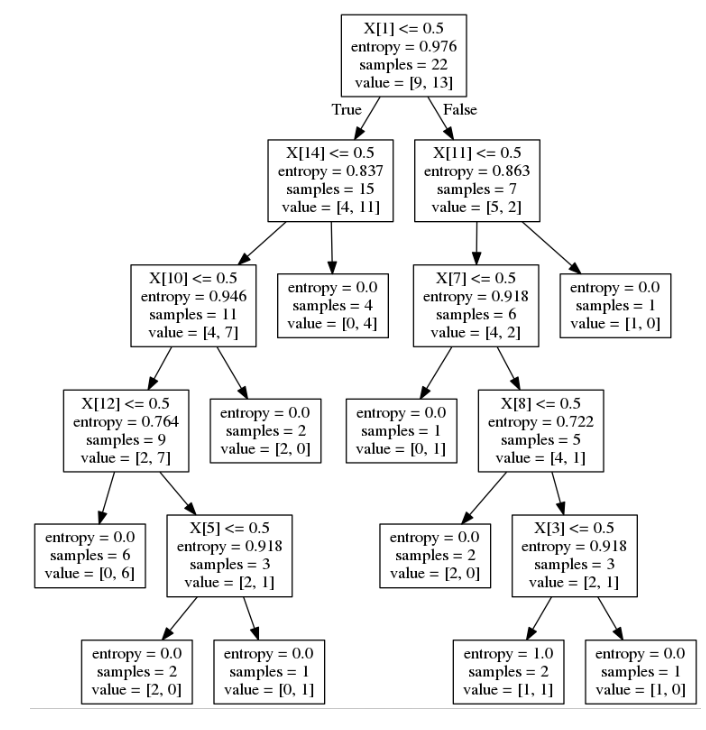

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
tree.export_graphviz(cls, out_file='tree.dot')  
!dot -Tpng tree.dot -o tree.png

plt.figure(figsize=(12,18))
plt.axis('off')
img=mpimg.imread('tree.png')
imgplot = plt.imshow(img)
plt.show()

Excellent! However, we don't know what each X_i means. Let's see what is the attribute value for each of them.

In [42]:
new_columns = []
columns = dataset.drop('Enjoy', 1).columns
ax = 0
for j in range(len(columns)):
    column = columns[j]
    encoder.fit_transform(dataset[column])
    for i in range(len(encoder.classes_)):
        print "x_"+str(ax)+": "+column+"_"+encoder.classes_[i]
        ax += 1

x_0: Occupied_High
x_1: Occupied_Low
x_2: Occupied_Moderate
x_3: Price_Cheap
x_4: Price_Expensive
x_5: Price_Normal
x_6: Music_Loud
x_7: Music_Quiet
x_8: Location_City-Center
x_9: Location_Ein-Karem
x_10: Location_German-Colony
x_11: Location_Mahane-Yehuda
x_12: Location_Talpiot
x_13: VIP_No
x_14: VIP_Yes
x_15: Favorite Beer_No
x_16: Favorite Beer_Yes


In [73]:
df_X = pd.DataFrame(X.toarray())
df_X['Enjoy'] = dataset['Enjoy']

In [106]:
root = construct_tree(df_X, 'Enjoy', prev_entropy)

In [107]:
print_tree(root)

1   (Entropy=0.976)
0.0: 8   (Entropy=0.837)
    0.0: 11   (Entropy=0.946)
        0.0: 0   (Entropy=1.0)
            0.0: 5   (Entropy=0.918)
                0.0: 13   (Entropy=0.918)
                    0.0: Leaf   (Entropy=0.0)
                        Prediction: Yes
                    1.0: Leaf   (Entropy=0.0)
                        Prediction: No
                1.0: Leaf   (Entropy=0.0)
                    Prediction: Yes
            1.0: Leaf   (Entropy=0.0)
                Prediction: No
        1.0: Leaf   (Entropy=0.0)
            Prediction: Yes
    1.0: Leaf   (Entropy=0.0)
        Prediction: Yes
1.0: 4   (Entropy=0.863)
    0.0: 6   (Entropy=0.918)
        0.0: 3   (Entropy=0.722)
            0.0: 8   (Entropy=0.918)
                0.0: Leaf   (Entropy=0.0)
                    Prediction: No
                1.0: 0   (Entropy=1.0)
                    0.0: 2   (Entropy=1.0)
                        0.0: 5   (Entropy=1.0)
                            1.0: 7   (Entropy=1.0)
